# LightGBMによる分析(データ更新日11/24)

In [65]:
# # 不要な警告文を非表示にする
import warnings
# warnings.filterwarnings("ignore", module='lightgbm')
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

# lightGBM
import lightgbm as lgb

# ポアソン分布での確率を計算するためのライブラリ
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib


# 今日の日付を取得
from datetime import datetime
today = datetime.today().date().strftime('%Y%m%d')

## 関数の定義
 * heatmap関数<br>
ヒートマップの描画時に利用。描画したい２次元のnumpy配列、軸ラベル（縦、横）、カラーバーの有無。プロット箇所とheatmap定義されたax、を今回は利用した<br>
 * annotate_heatmap関数<br>
描画したヒートマップのセルに、要素の値をテキスト形式で描画する関数<br>
 * form_streak関数<br>
戦績を最大五試合分さかのぼって取得して、試合結果に応じて、数値を付与。また、新しい試合程、反映するよう重みづけを行い、数値化した。<br>

In [66]:
#参照：https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, 
            row_labels, 
            col_labels, 
            ax = None,
            bar = True, 
            cbar_kw = None, 
            cbarlabel = "", 
            **kwargs):
    """
    numpyの2次元配列リスト形式のリスト２つからヒートマップを作成する

    Parameters
    ----------
    data
        ２次元(n,m)のnumpy配列を受け取る
    row_labels
        長さmの配列を渡す。
    col_labels
        長さnの配列を渡す.
    ax
        ヒートマップとプロットしたい箇所を受け取る
    bar
        boolean形式。指定されなければ、カラーバーを作成する
    cbar_kw
       カラーバーの引数
    cbarlabel
        カラーバーのラベル

    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # ヒートマップの描画
    im = ax.imshow(data, **kwargs)

    # カラーバーの作成
    if bar == True:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # 軸の長さと要素ごとに登録したいラベルを指定する.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    #グリッドを作成
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    if bar == True:
        return im, cbar
    else :
        return im, _

def annotate_heatmap(im, 
                     data=None, 
                     valfmt="{x:.2f} ",
                     textcolors=("black", "black"),
                     threshold=None,
                     **textkw):
    """
    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        プロットしたデータを受け取る。指定されなければ、プロットされたセルの情報をそのまま書きこむ
    valfmt
        セルに書き込みたい形式を文字列形式で受け取る.  
    textcolors
       文字色を２つ受け取る。第一引数には、通常色、第二引数には閾値を超えた場合更新する色が入る
       指定がなければ黒一色で記入する
    threshold
        指定された数値以上になれば、文字色をtextcolorsで受け取った第二引数のカラーに更新する。
        特に指定しなければ、セル全体の最大値の1/2以上の値であれば色を更新する
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # 閾値の登録
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # 指定した形式でセル内に文字列を入力するよう処理
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # セルに文字列を入力する
    # 閾値を超えていれば文字色をtextcolorsの第二引数として受け取ったカラーになる
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts
    
# df_form_log['form_home'] or df_form_log['form_away']の値を１行ずつ受け取り、その文字列をxとする
def form_streak(x):
    # 返却値の初期化
    ans = 0
    # 細心の試合程重みを大きくするため、戦績を反転する
    st = x[::-1]
    # 文字に応じて、勝ち点を登録
    # 負け=0, 引き分け=1, 勝ち=3
    for j in range(1,len(st)+1):
        # 勝ち点を登録
        if st[j-1] == 'W':
            res = 3
        elif st[j-1] == 'D':
            res = 1
        else :
            res = 0
        # 重みを付与する数式の登録（先行研究より）
        p = len(st) - j
        ans1 = (p - (p - 1))*res
        ans2 = j * (j + 1)
        ans3 = ans1 / ans2
        ans += (2 * ans3/3)
    return ans

## データフレームの生成

### 戦績データ（テキスト形式）の数値化

In [67]:
# 作成したフォームログを含んだデータフレームを取り込む
df_form_log = pd.read_csv('../api_data/fixture_form.csv')

#欠損値を補完する
df_form_log = df_form_log.fillna('0')
# df_form_logと、df_team_statistics（結合したいカラム（home_powerとaway_power）を持つデータフレーム）
##の統合するためのキーとなるカラム名の統合
df_form_log = df_form_log.rename(columns={'team.id':'home_id',
                                          'away.id':'away_id'})
#実装3で作成した、チームスタイルとチームIDを持ったデータフレームの必要な列のみ結合する。
# applyを用いてdf_form_log['form_home']の値を一行ずつ渡して、関数にかける
# 結果も一行ごとに帰ってきてインデックスごとに格納される
df_form_log['streak_home']  = df_form_log['form_home'].apply(form_streak)
df_form_log['streak_away']  = df_form_log['form_away'].apply(form_streak)

# カラム[form_home、form_away]は不要になるので削除する
df_form_log = df_form_log.drop(columns={'form_home',
                                        'form_away'})

print(df_form_log.shape)
df_form_log.head(5)

(306, 7)


,home_id,away_id,fixture.id,fixture.date,game_flg,streak_home,streak_away
0,294,296,982843,20230217,True,0.0,0.0
1,281,293,982844,20230218,True,0.0,0.0
2,292,287,982845,20230218,True,0.0,0.0
3,307,288,982846,20230218,True,0.0,0.0
4,302,290,982847,20230218,True,0.0,0.0


### ホームチームの攻撃力とアウェイチームの攻撃力を付与した、対戦表データフレーム(df_team_statistics)を作成

In [68]:
# チームごとの統計量を持ったデータフレームを取り込む（ホームでの得点数・失点数、アウェイでの得点数、失点数を取得するため）
df_team_statistics = pd.read_csv('../api_data/statistics/team/team_statistics_2023.csv')
# playedが最大かつteam.idが一意になるように変更
df_team_statistics = df_team_statistics.loc[df_team_statistics.groupby('team.id')['played'].idxmax()]
# ホームチームの攻撃力とアウェイチームの攻撃力を求めるためのカラムのみ抽出する
df_team_statistics = df_team_statistics[['team.id',
                                         'goals.for.average.home',
                                         'goals.for.average.away',
                                         'goals.against.average.home',
                                         'goals.against.average.away']]

# 試合の結果を持つcsvファイルを取り込む
df_result = pd.read_csv("../api_data/fixtures/fixtures_2023.csv")

# １．df_team_statisticsをteam_idを軸にクロス結合
# ２．df_testをクロス結合して、対戦データを作成する。
# ３．同じチームidを持つインデックスは比較対象外なので、取り除く。不要なカラムを削除する
df_team_statistics = \
        pd.merge(df_team_statistics,
                 df_team_statistics,how='cross').\
                        query('`team.id_x` != `team.id_y`').\
                            drop(columns={'goals.for.average.away_x',
                                          'goals.against.average.away_x',
                                          'goals.for.average.home_y',
                                          'goals.against.average.home_y'})

# df_team_statisticsと複数キーをもとに結合するため、カラム名を統合する
df_result = df_result.rename(columns={'teams.home.id':'team.id_x','teams.away.id':'team.id_y'})
# 複数キーを条件として、試合結果を結合（未開催分の結果は欠損値が入る）＆（欠損値部分を予測したい）
df_team_statistics = pd.merge(df_team_statistics,
                               df_result[['team.id_x','team.id_y','goals.home','goals.away']],
                               on=['team.id_x','team.id_y'], how='inner')

# 単純平均法により、{(goals.for.average.home_x + goals.against.average.away_y) / 2}をホームチームの得点予測値、
#                 {(goals.against.average.home_x + goals.for.average.away_y) / 2}をアウェイチームの得点予測値とする
df_team_statistics[['home_power','away_power']] = \
                            df_team_statistics.apply(lambda d:
                                    [
                                        (d['goals.for.average.home_x'] + d['goals.against.average.away_y']) / 2,
                                        (d['goals.against.average.home_x'] + d['goals.for.average.away_y']) / 2
                                    ],axis = 1, result_type='expand')

# ホームチームの得点予測値、アウェイチームの得点予測値を求めるために使ったカラムは使用しないため削除する
df_team_statistics = df_team_statistics.drop(columns={'goals.for.average.home_x',
                                                      'goals.against.average.home_x', 
                                                      'goals.for.average.away_y',
                                                      'goals.against.average.away_y'})

# ドットは通常、オブジェクトの属性にアクセスするために使用されるためPatsyErrorが発生するため、列名の変更をする
# ここまでの作業で、カラムが['team_id_x', 'team_id_y', 'goals_home', 'goals_away', 'home_power','away_power']となる
df_team_statistics.columns = df_team_statistics.columns.str.replace('.','_')
df_team_statistics.head(5)

,team_id_x,team_id_y,goals_home,goals_away,home_power,away_power
0,279,281,1.0,2.0,1.45,1.2
1,279,282,0.0,0.0,1.25,1.2
2,279,284,0.0,1.0,1.60,1.4
3,279,287,NaN,NaN,1.20,1.2
4,279,288,1.0,2.0,1.45,1.3


### 対戦表データフレームに戦績データのカラムを結合する

In [69]:
#df_form_logとdf_team_statisticsを結合して、必要なカラムを持ったデータフレームを作成する
# 準備:カラム名の統合
df_team_statistics = df_team_statistics.rename(columns={'team_id_x':'home_id',
                                                        'team_id_y':'away_id'})
df_form = pd.merge(df_team_statistics,
                   df_form_log,  
                   on=['home_id','away_id'])
#このうち説明変数を標準化する（得点はカウントデータなので、標準化しない）
scaler = StandardScaler()
df_form[['streak_home', 'streak_away', 'home_power', 'away_power']] = \
                scaler.fit_transform(df_form[['streak_home', 
                                              'streak_away',
                                              'home_power', 
                                              'away_power']])
df_form.head(5)

,home_id,away_id,goals_home,goals_away,home_power,away_power,fixture.id,fixture.date,game_flg,streak_home,streak_away
0,279,281,1.0,2.0,0.246651,0.086502,994863,20230930,True,-0.335378,-0.372746
1,279,282,0.0,0.0,-0.493301,0.086502,994890,20231111,True,0.717215,1.348942
2,279,284,0.0,1.0,0.801614,0.976237,994845,20230916,True,0.877163,-0.722832
3,279,287,NaN,NaN,-0.678289,0.086502,994908,20231203,False,-0.001950,-0.613485
4,279,288,1.0,2.0,0.246651,0.531369,994737,20230527,True,1.695986,1.041983


### 対戦表データフレーム(df_formに名称変更)にチーム名と試合日程を付与したデータフレームを新規作成する
まだ開催されていない試合を対象とする

In [70]:
#予測したい試合のインデックスを保存（欠損値があるとモデルに入力できないため）
df_test_data = df_form.loc[df_form['goals_home'].isna()]

#　インデックスの初期化
df_test_data = df_test_data.sort_values('home_id').reset_index(drop=True)
#チーム名とチームid（キーにしたいカラム）を持ったcsvを取り込む
df_standing = pd.read_csv('../api_data/standing/standing_2023.csv')
# 必要なカラムのみに更新
df_standing = df_standing[['team.id', 'team.name']]
df_standing_home = df_standing.rename(columns={'team.id':'home_id'})
df_standing_away = df_standing.rename(columns={'team.id':'away_id'})
# データフレームをコピーする。（テキストを含んだカラムがあると、説明変数として指定していなくともエラーが生じる。。）
df_team_name = df_test_data.copy()
# ホームidをキーとして、ホームチーム名を結合
df_team_name = pd.merge(df_team_name, df_standing_home, on='home_id')
#アウェイidをキーとして、アウェイチーム名を結合
df_team_name = pd.merge(df_team_name, df_standing_away, on='away_id')
df_team_name = df_team_name.sort_values('home_id').reset_index(drop=True)

# チーム名の空白を埋める
df_team_name[['team.name_x', 'team.name_y']] = df_team_name[['team.name_x', 'team.name_y']].apply(lambda x: x.str.replace(' ', ''))
df_team_name.head(5)


,home_id,away_id,goals_home,goals_away,home_power,away_power,fixture.id,fixture.date,game_flg,streak_home,streak_away,team.name_x,team.name_y
0,279,287,NaN,NaN,-0.678289,0.086502,994908,20231203,False,-0.001950,-0.613485,ConsadoleSapporo,Urawa
1,281,295,NaN,NaN,-1.048265,0.976237,994900,20231125,False,-0.185177,-0.952689,KashiwaReysol,SaganTosu
2,282,293,NaN,NaN,1.726554,-1.248100,994907,20231125,False,0.429638,-1.403398,SanfrecceHiroshima,GambaOsaka
3,284,292,NaN,NaN,-0.493301,0.308936,994910,20231203,False,1.368753,-0.482758,ShonanBellmare,FCTokyo
4,287,316,NaN,NaN,0.061663,-0.803233,994899,20231125,False,-0.514334,0.887101,Urawa,AvispaFukuoka


### 開催済みの試合データを拡張する
開催済みの試合データが少なすぎる（11/08時点で１チームあたり15試合）という問題点がある。<br>
対応策として、開催分の試合データを10倍にしてテストデータを人為的に拡張した。<br>
ただ拡張するだけではなく、目的変数、説明変数に微小な疑似乱数を付与して過学習を避けるような対応を施した<br>

In [93]:
# #　データが少ないためデータの拡張を行う。欠損値の入ったデータを拡張してもしょうがないので、欠損値を除去してから拡張する
df_form = df_form.dropna()
df_form_sub = df_form.copy() 
# データを今の10倍にする
for i in range(20):
    # データ拡張の際に、目的変数、説明変数を微小な乱数で修正する
    random_value = np.random.uniform(0.025)
    exp_data = df_form_sub.copy()
    exp_data[['goals_home', 'goals_away', 'home_power','away_power', 'streak_home', 'streak_away']] += random_value
    
    # 作成したデータフレームを、縦方向に結合する
    if i == 0:
        df_form_2 = pd.concat([df_form,pd.DataFrame(exp_data)])
    else :
        df_form_2 =pd.concat([df_form_2, pd.DataFrame(exp_data)])
df_form_2.head(5)

,home_id,away_id,goals_home,goals_away,home_power,away_power,fixture.id,fixture.date,game_flg,streak_home,streak_away
0,279,281,1.0,2.0,0.246651,0.086502,994863,20230930,True,-0.335378,-0.372746
1,279,282,0.0,0.0,-0.493301,0.086502,994890,20231111,True,0.717215,1.348942
2,279,284,0.0,1.0,0.801614,0.976237,994845,20230916,True,0.877163,-0.722832
4,279,288,1.0,2.0,0.246651,0.531369,994737,20230527,True,1.695986,1.041983
5,279,289,1.0,3.0,-0.493301,2.088405,994622,20230225,True,-0.880344,0.348337


## モデルの実装
チームごと(18通り)、ホーム戦アウェイ戦ごと（2通り）にモデルを作成（18*2 = 36models）<br>
拡張済みのデータフレームから、必要なチームidを持つインデックスのみ取り出してモデル作成する

In [94]:
df_form = df_form.dropna()
#上記のような分析を各ホームチームごと、各アウェイチームごとに学習させたモデルを作りたい
## ホームチームのidをユニーク形式で取得(アウェイチームも同じなので転用する)
home_id_list = df_form['home_id'].unique()
#home_id_listの長さはよく使うので変数として定義
ids = len(home_id_list)
res_home = []
res_away = []
train_data = [0]*ids
val_data = [0]*ids
predictions_home = [0]*ids
predictions_away = [0]*ids

for i, id in enumerate(home_id_list):
    # 指定されたhome_idのみのデータフレームを作成する
    ## データ拡張しなかった場合
    # df_form_home = df_form.loc[df_form['home_id'] == id]
    ## データ拡張した場合
    df_form_home = df_form_2.loc[df_form_2['home_id'] == id]

    # トレーニングデータ、バリテーションデータの生成
    train_data[i], val_data[i] = train_test_split(df_form_home, test_size=0.2)
    
    # train_dataを目的変数と説明変数に分ける
    ## 目的変数
    y = train_data[i]['goals_home']
    ## 説明変数
    X = train_data[i][['home_power', 'streak_home', 'streak_away']]
    
    # val_dataを目的変数と説明変数に分ける
    ## 目的変数
    y_val = val_data[i]['goals_home']
    ## 説明変数
    X_val = val_data[i][['home_power', 'streak_home', 'streak_away']]
    
    # モデルの構築
    model = lgb.LGBMRegressor(objective = 'poisson', verbose=-1)
    res_home.append(model.fit(X, y))
    
    # モデルの評価
    predictions_home[i] = res_home[i].predict(X_val)
    mse = mean_squared_error(y_val, predictions_home[i])
    msle = mean_squared_log_error(y_val, predictions_home[i])
    print(f'ホーム戦でのteamid = {id} の精度')
    print('平均二乗誤差：', mse)
    print('平均二乗対数誤差；', msle)
    
    # 各チームのアウェイ戦の得点数ポアソン回帰モデルの作成
    ## データ拡張しなかった場合
    df_form_away = df_form.loc[df_form['away_id'] == id]
    ## データ拡張した場合
    # df_form_away = df_form_2.loc[df_form_2['away_id'] == id]
    ## トレーニングデータ、バリテーションデータの生成
    train_data[i], val_data[i] = train_test_split(df_form_away, test_size=0.2)
    ## 目的変数と説明変数に分割する
    y = train_data[i]['goals_away']
    X = train_data[i][['away_power', 'streak_home', 'streak_away']]
    
    # val_dataを目的変数と説明変数に分ける
    ## 目的変数
    y_val = val_data[i]['goals_away']
    ## 説明変数
    X_val = val_data[i][['away_power', 'streak_home', 'streak_away']]
    
    # モデルの構築
    model = lgb.LGBMRegressor(objective = 'poisson', verbose=-1)
    res_away.append(model.fit(X, y))
    
    # モデルの評価
    predictions_away[i] = res_away[i].predict(X_val)
    mse = mean_squared_error(y_val, predictions_away[i])
    # msle = mean_squared_log_error(y_val, predictions_away[i])
    print(f'アウェイ戦でのteamid = {id} の精度')
    print('平均二乗誤差：', mse)
    # print('平均二乗対数誤差；', msle)
    print('------------------------')

ホーム戦でのteamid = 279 の精度
平均二乗誤差： 0.7336926146367188
平均二乗対数誤差； 0.07402454290550309
アウェイ戦でのteamid = 279 の精度
平均二乗誤差： 1.6875
------------------------
ホーム戦でのteamid = 281 の精度
平均二乗誤差： 0.1581648076155837
平均二乗対数誤差； 0.027206205452990045
アウェイ戦でのteamid = 281 の精度
平均二乗誤差： 1.0277777777777777
------------------------
ホーム戦でのteamid = 282 の精度
平均二乗誤差： 0.21989599431596688
平均二乗対数誤差； 0.031205369052661424
アウェイ戦でのteamid = 282 の精度
平均二乗誤差： 0.8611111111111109
------------------------
ホーム戦でのteamid = 284 の精度
平均二乗誤差： 0.33693430339089997
平均二乗対数誤差； 0.07149475182562805
アウェイ戦でのteamid = 284 の精度
平均二乗誤差： 0.6736111111111112
------------------------
ホーム戦でのteamid = 287 の精度
平均二乗誤差： 0.2722413332004389
平均二乗対数誤差； 0.040031602583590904
アウェイ戦でのteamid = 287 の精度
平均二乗誤差： 0.5902777777777778
------------------------
ホーム戦でのteamid = 288 の精度
平均二乗誤差： 0.14777094303324503
平均二乗対数誤差； 0.02675555372183851
アウェイ戦でのteamid = 288 の精度
平均二乗誤差： 1.25
------------------------
ホーム戦でのteamid = 289 の精度
平均二乗誤差： 0.3174857356233262
平均二乗対数誤差； 0.05176899259512783
アウェイ

## テストデータの可視化
1. 未試合分を対象のモデルにかけてチームごとの得点予測値を求める
2. その得点をもとに、0~5の幅でそれぞれの事象発生率（得点する確率）を求める
3. 事象発生率をチームごとに棒グラフで表現する
4. 求めた事象発生率を、独立と仮定して、事象ごとの発生率をヒートマップで表現する

C:\Users\haruc\AppData\Local\Temp\ipykernel_34592\1521995996.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_home_goals = float(res_home[home_id_index].predict(home_param))
C:\Users\haruc\AppData\Local\Temp\ipykernel_34592\1521995996.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_away_goals = float(res_away[away_id_index].predict(away_param))
C:\Users\haruc\AppData\Local\Temp\ipykernel_34592\1521995996.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumP

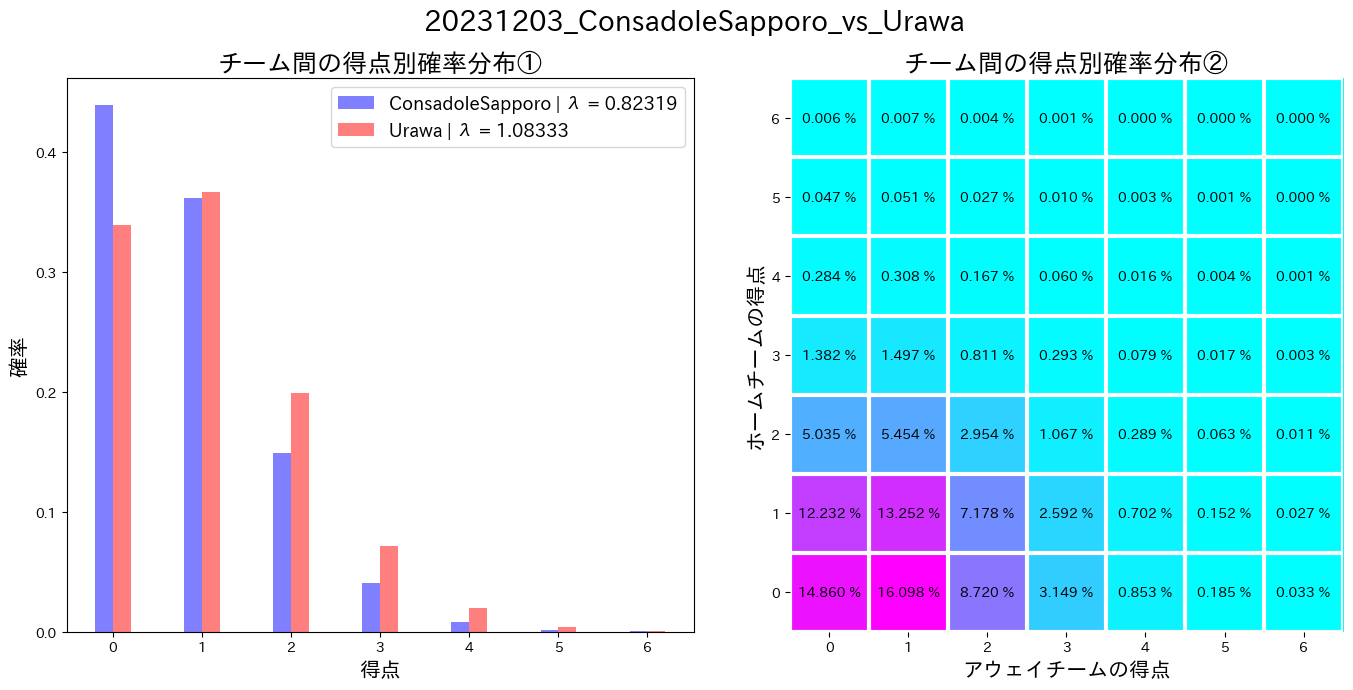

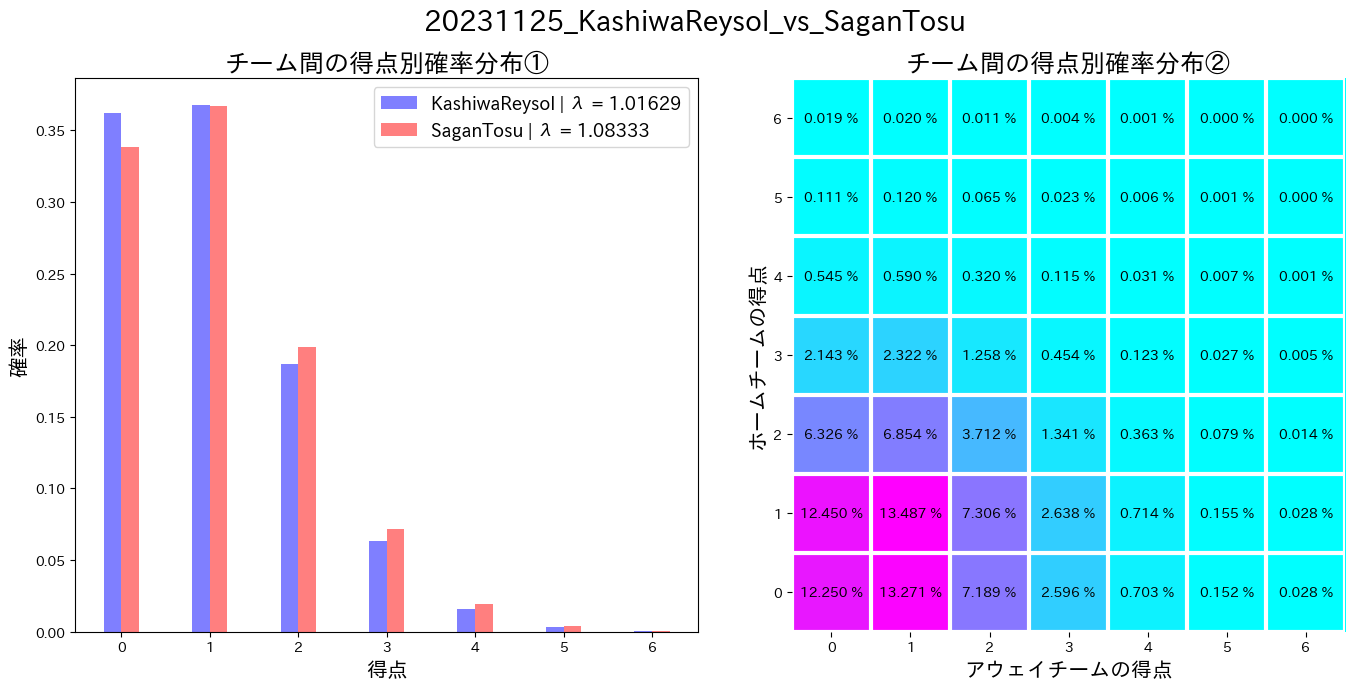

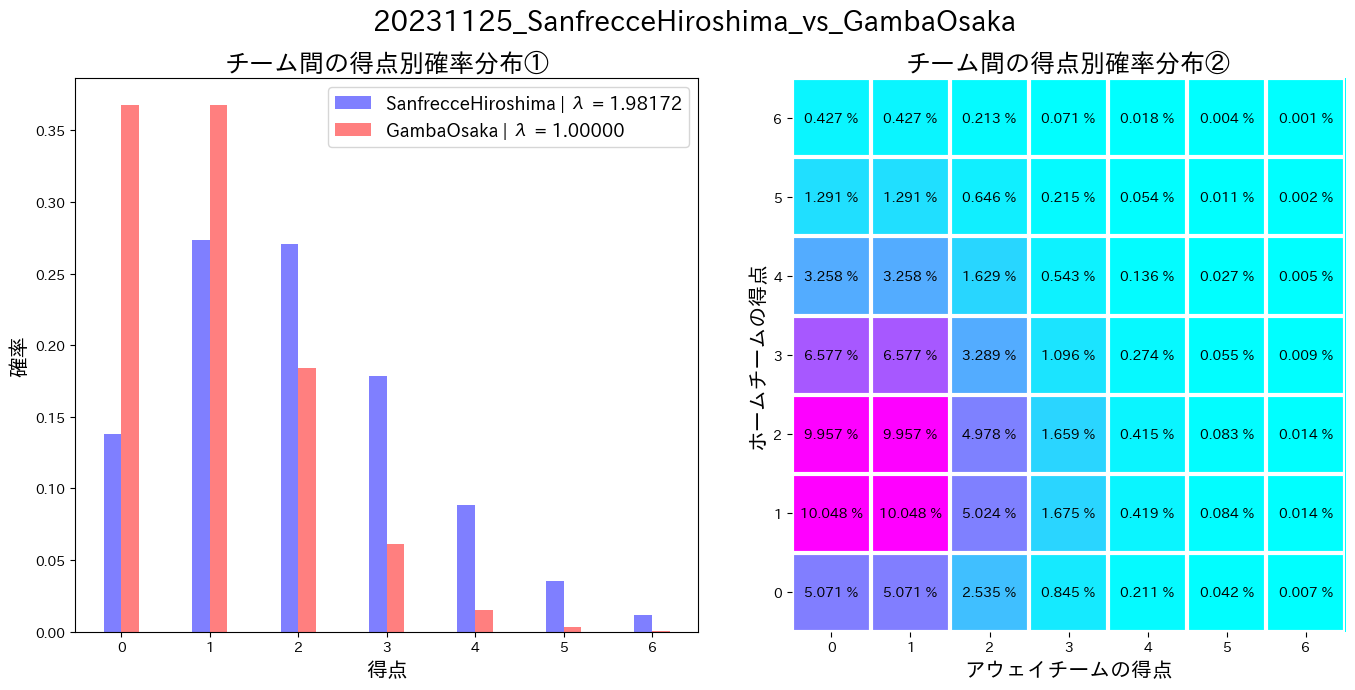

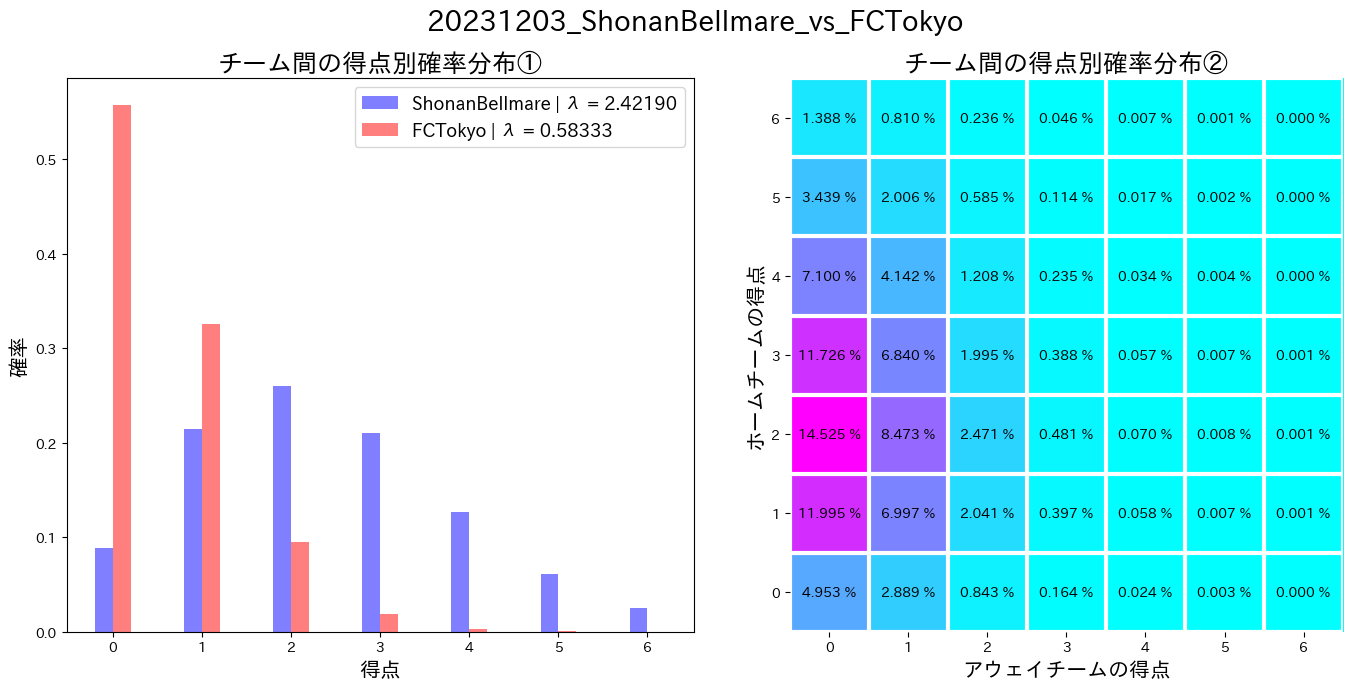

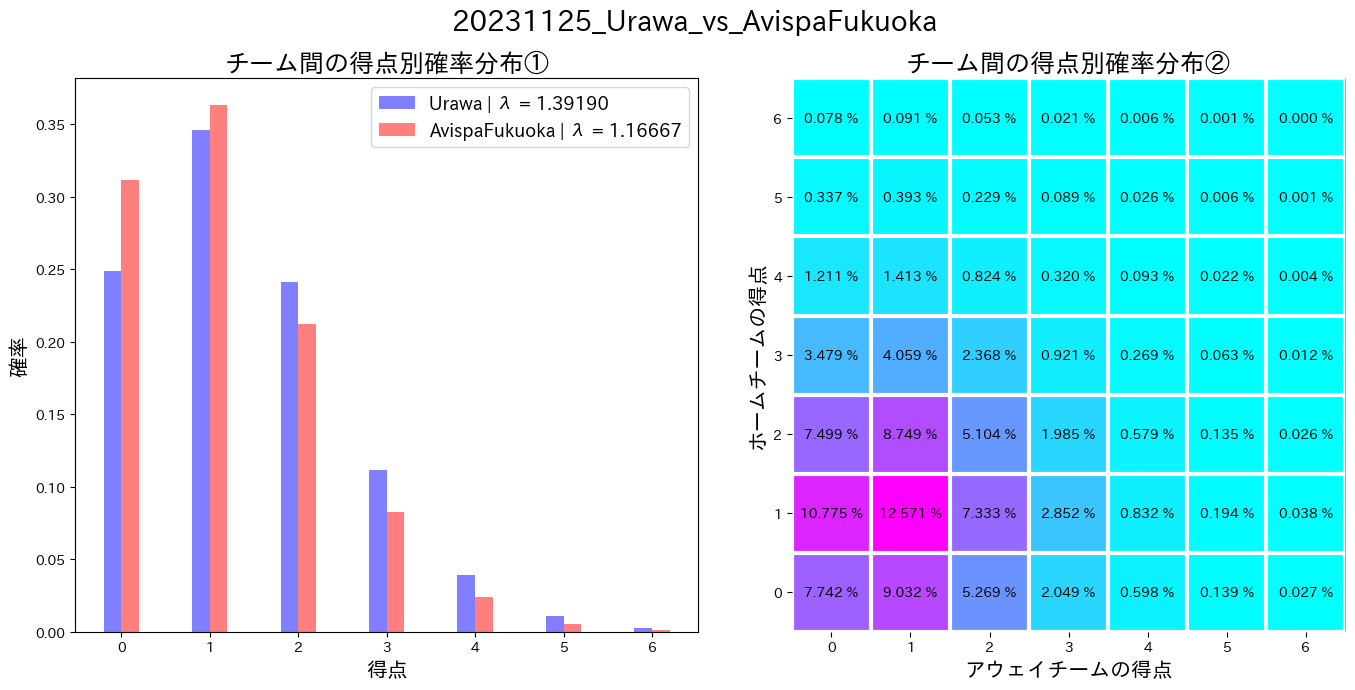

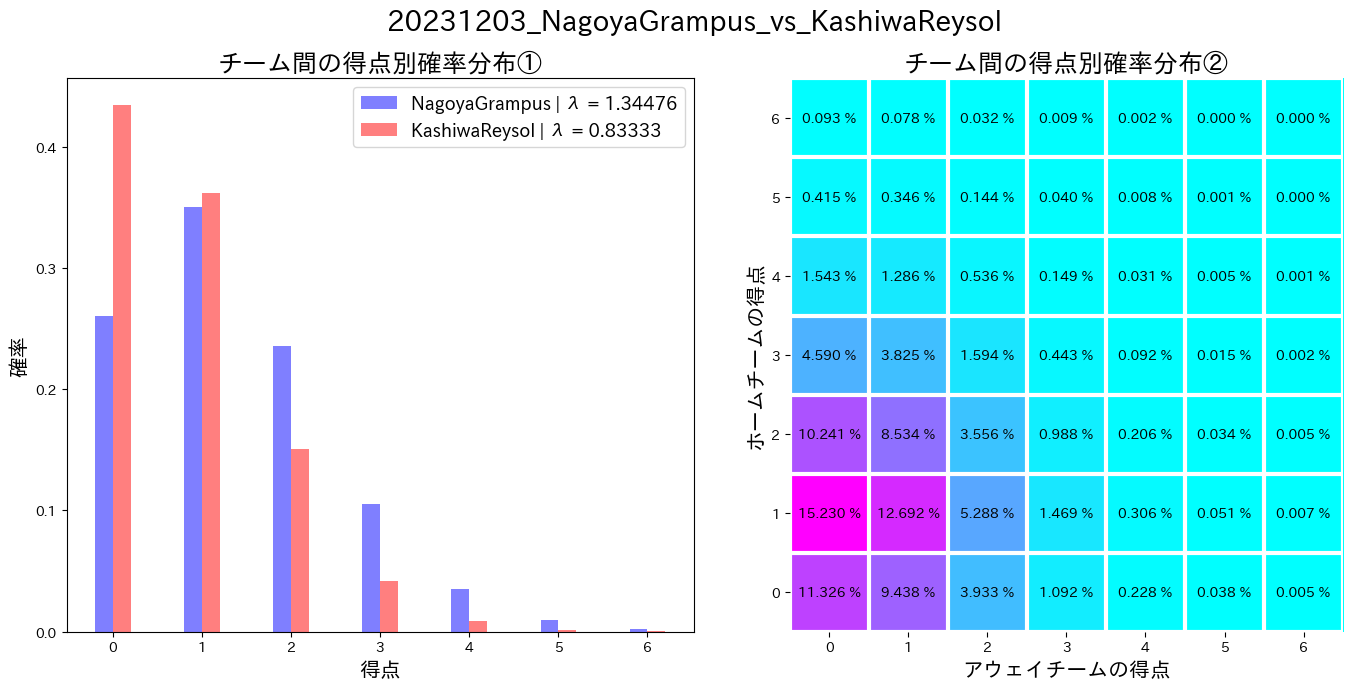

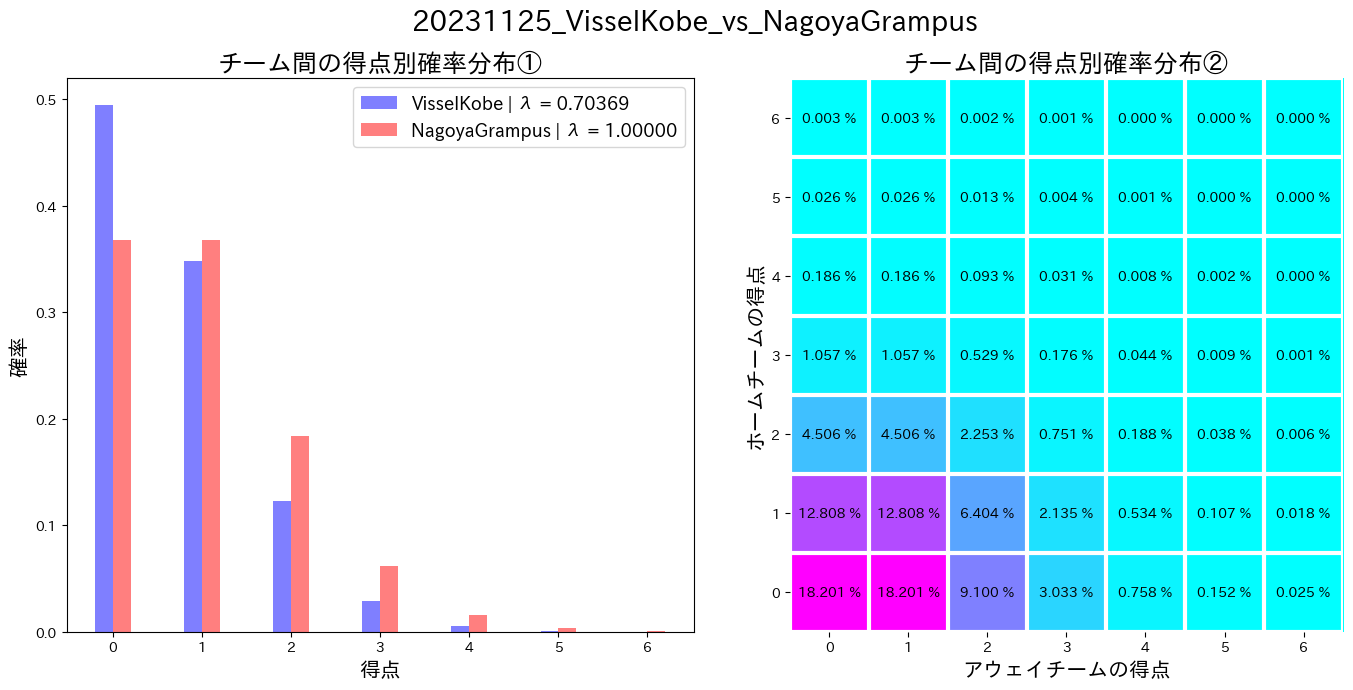

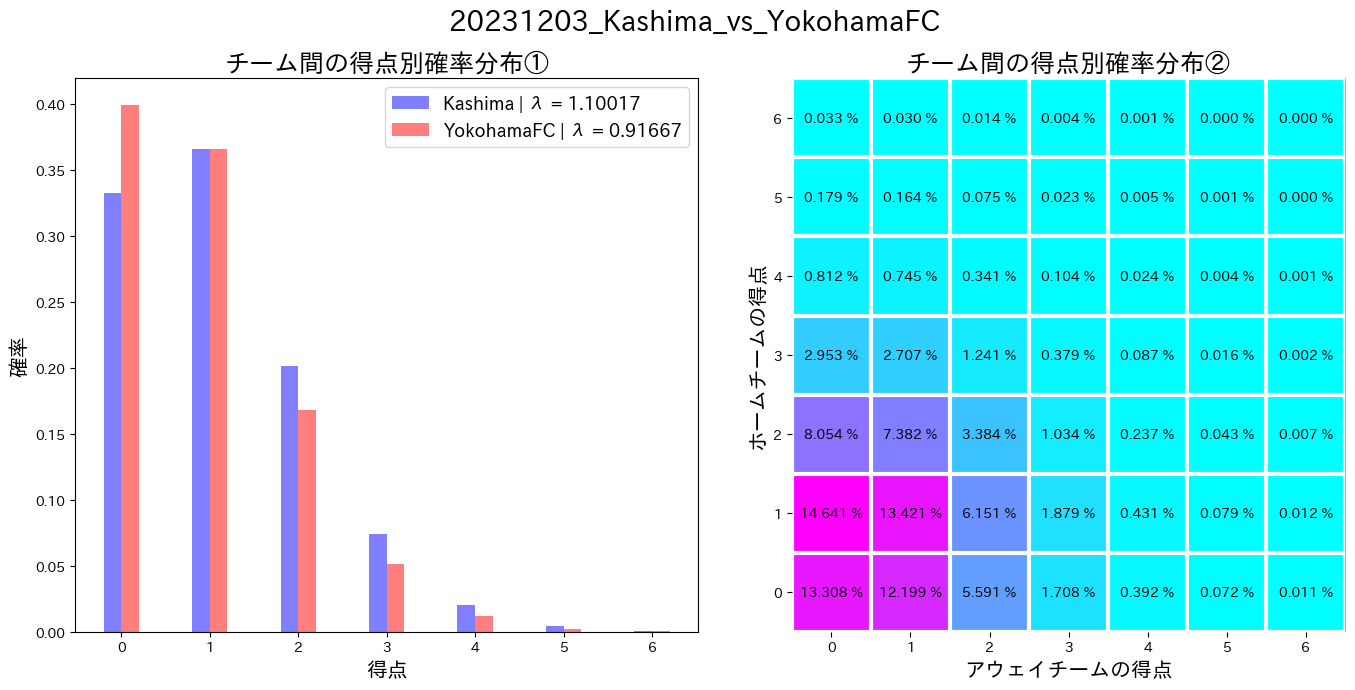

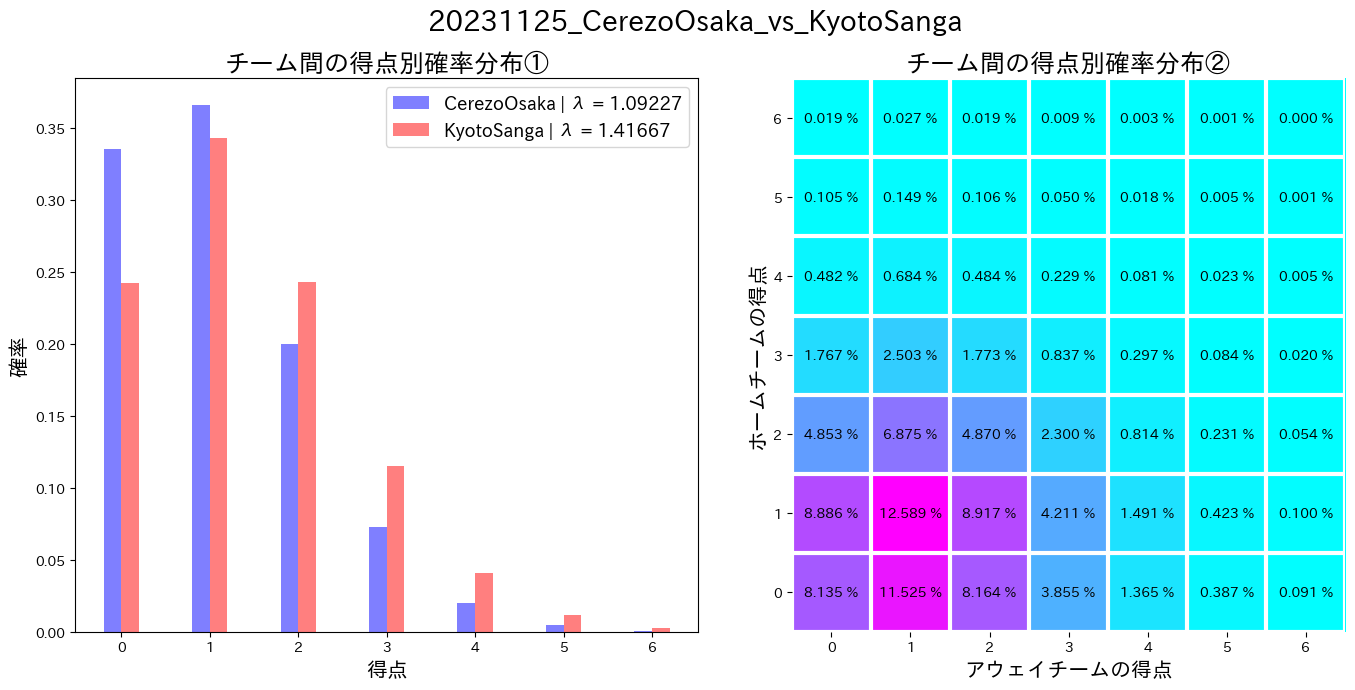

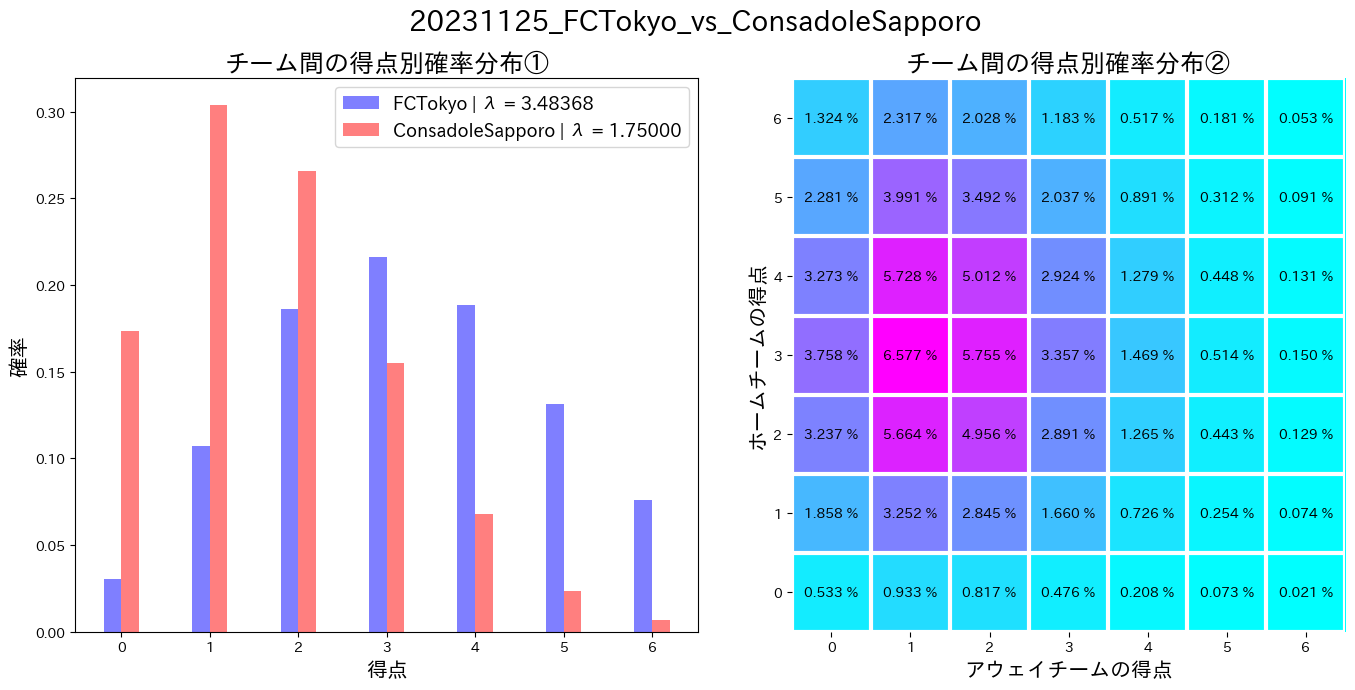

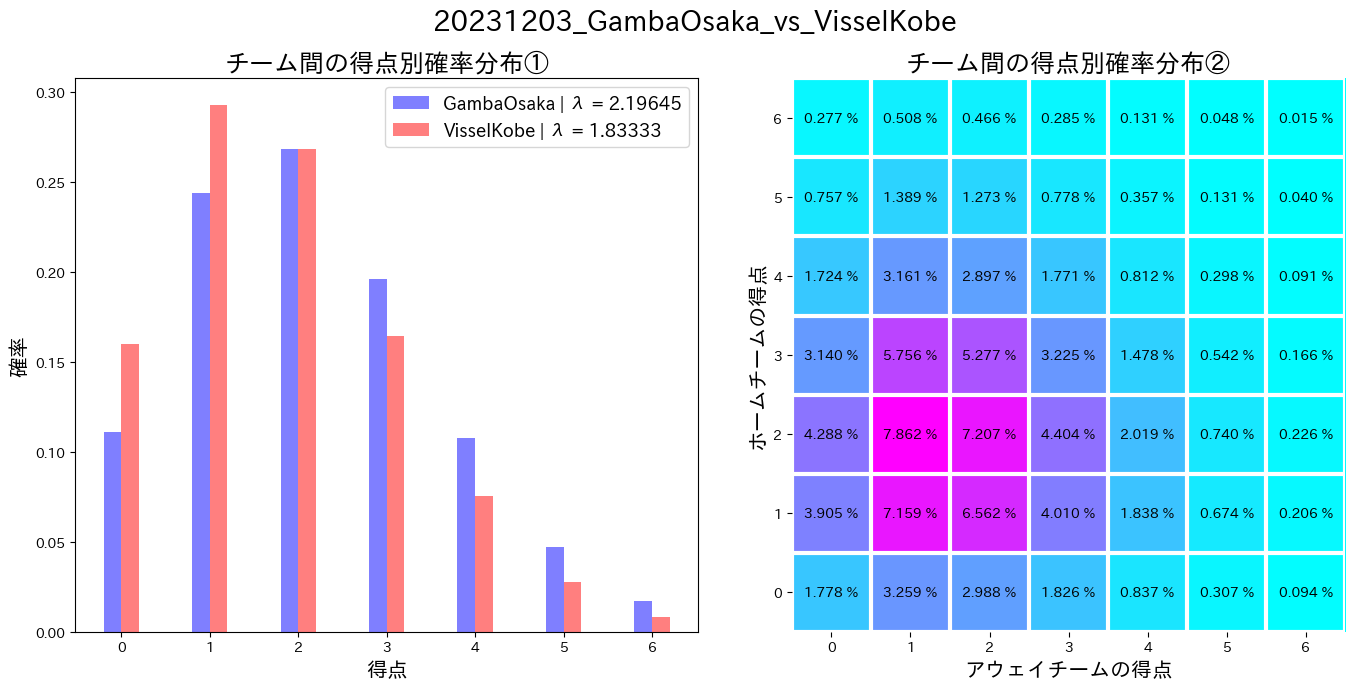

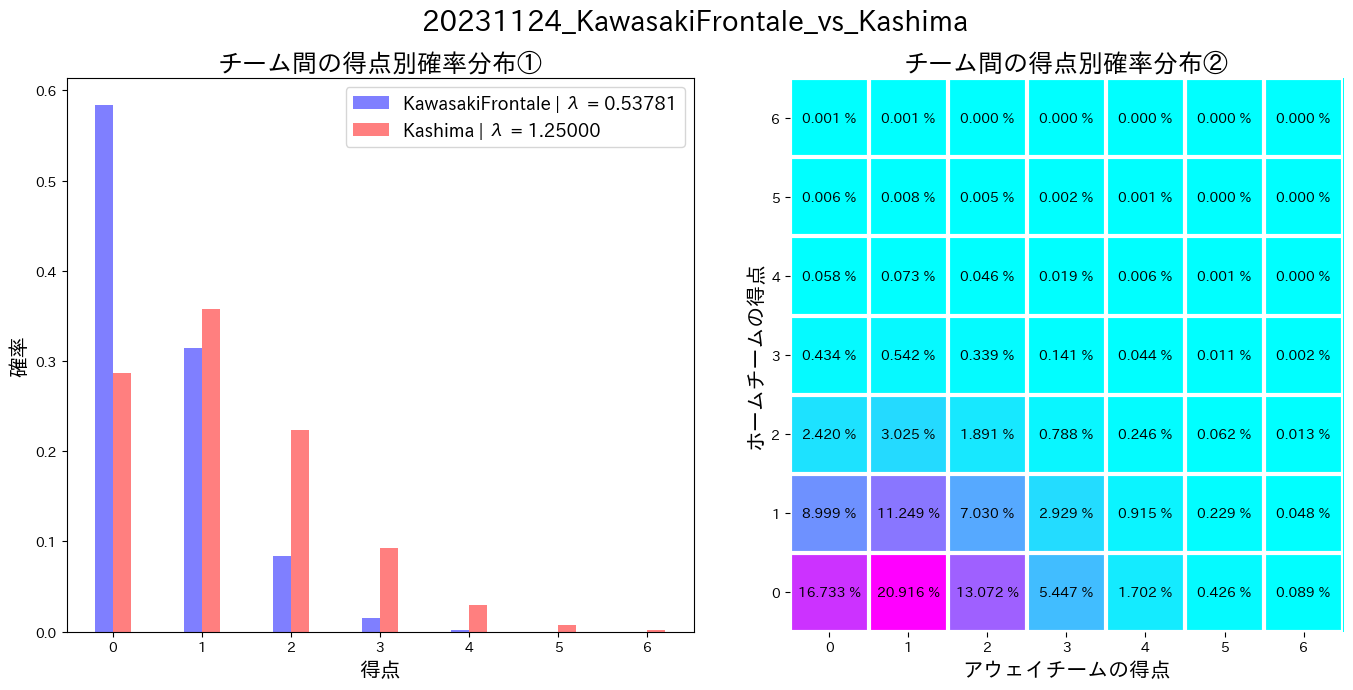

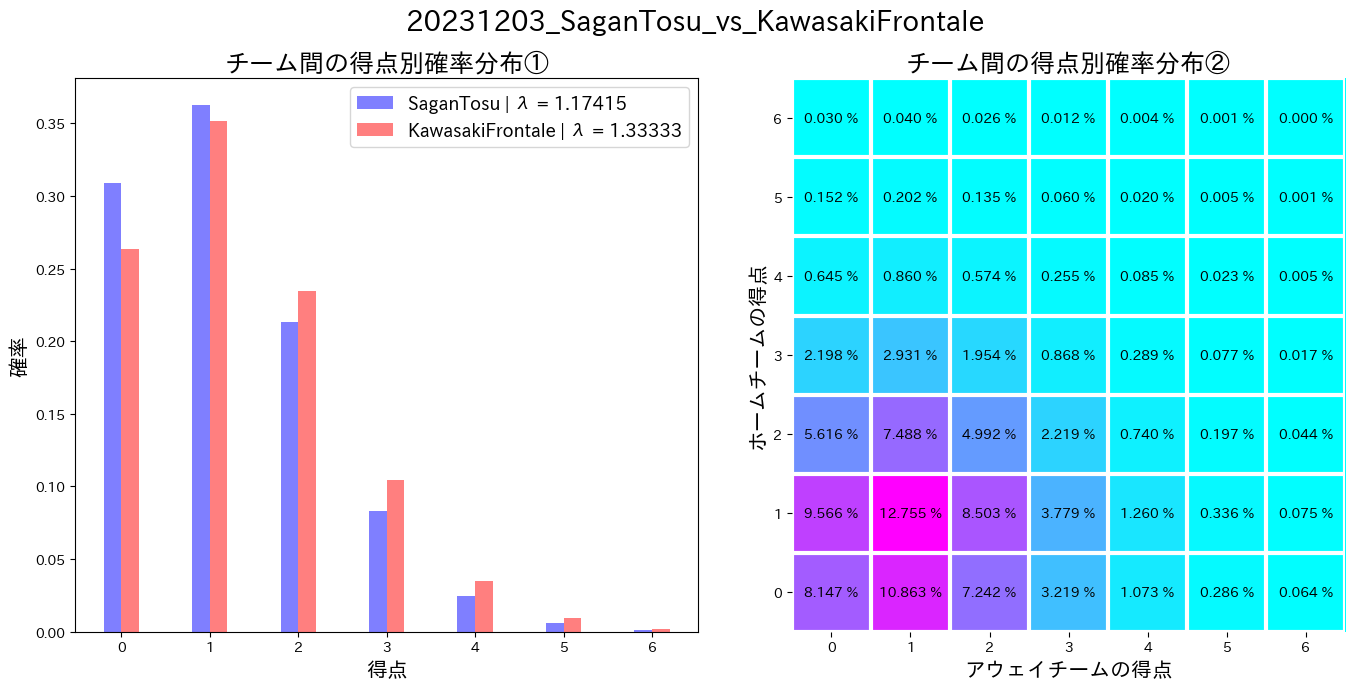

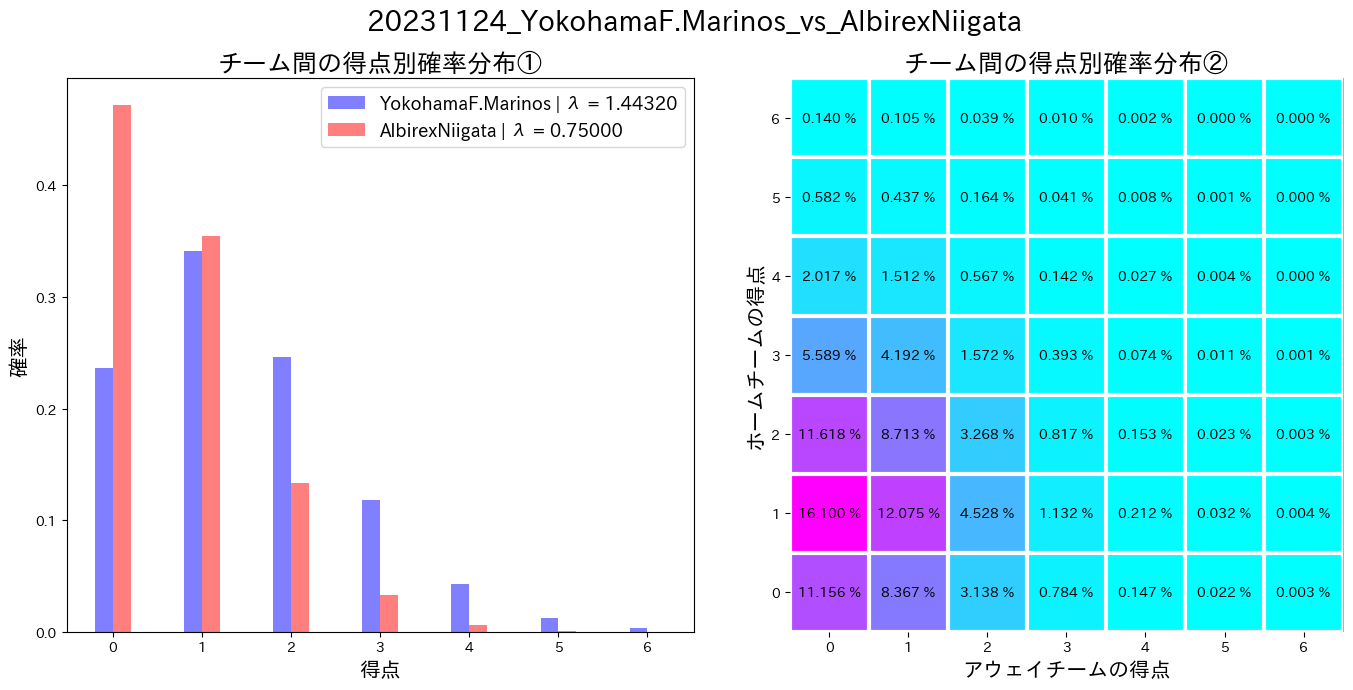

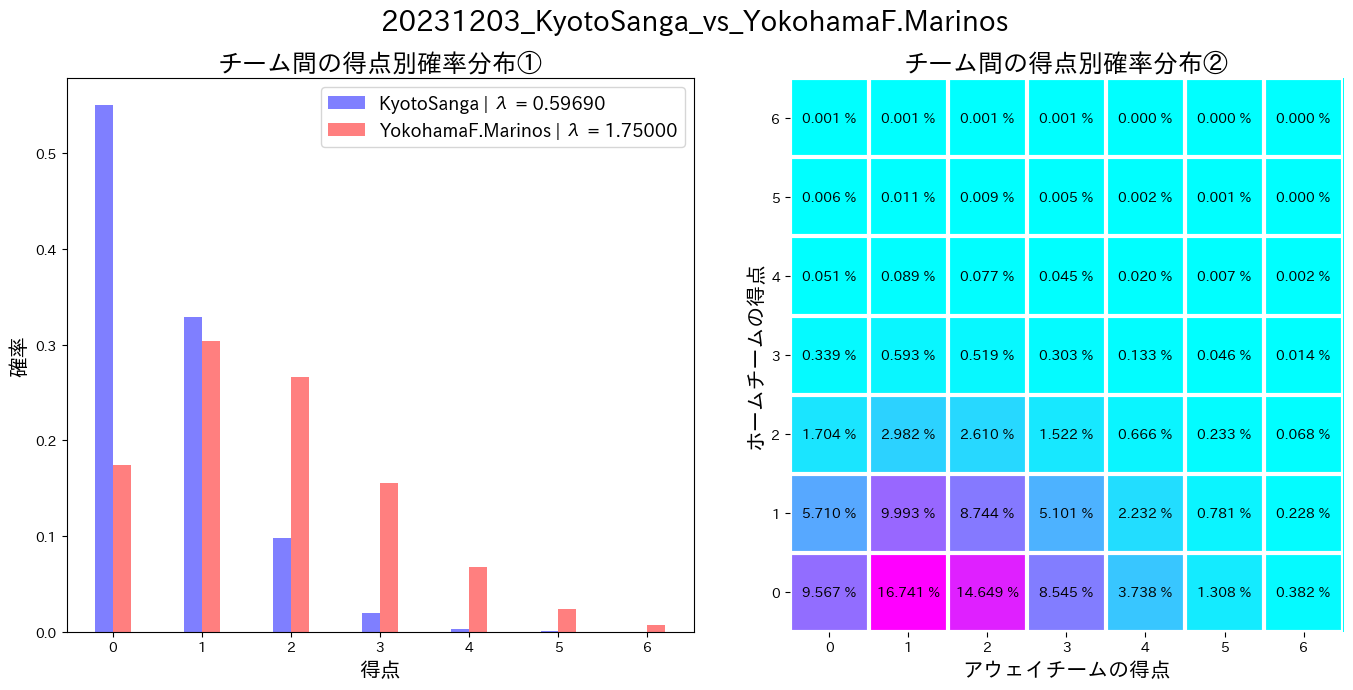

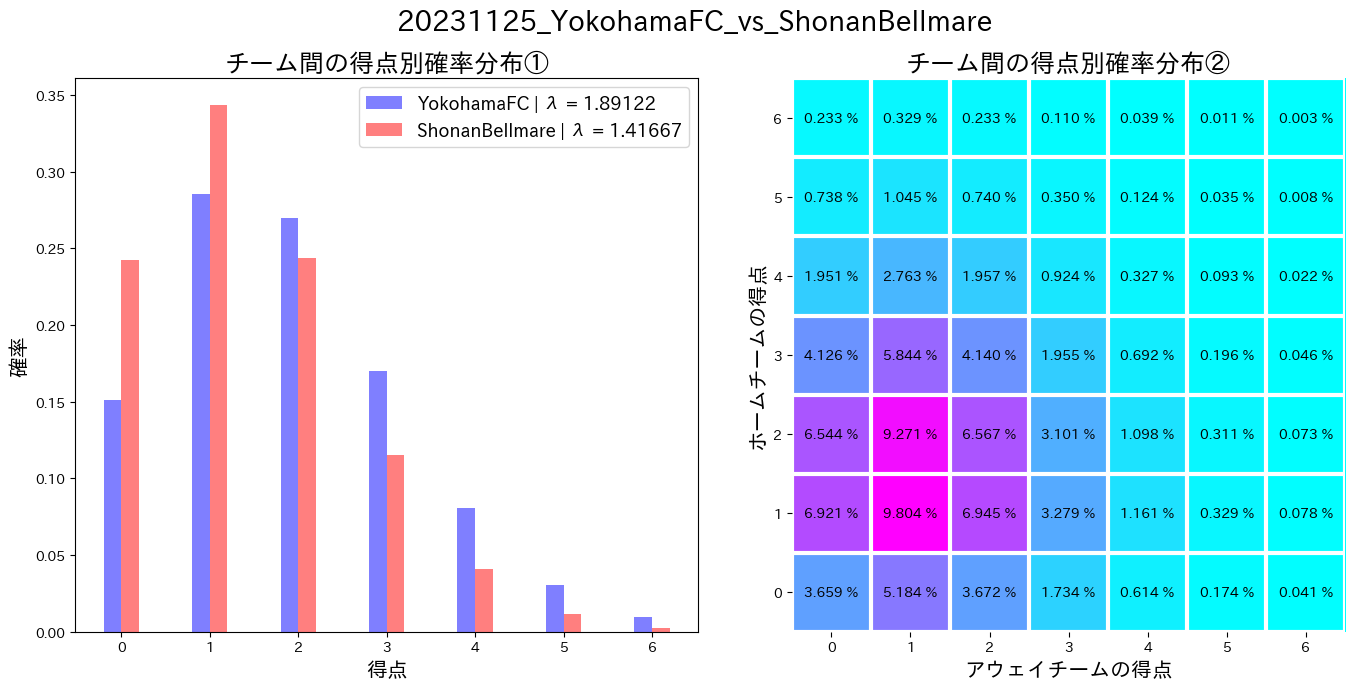

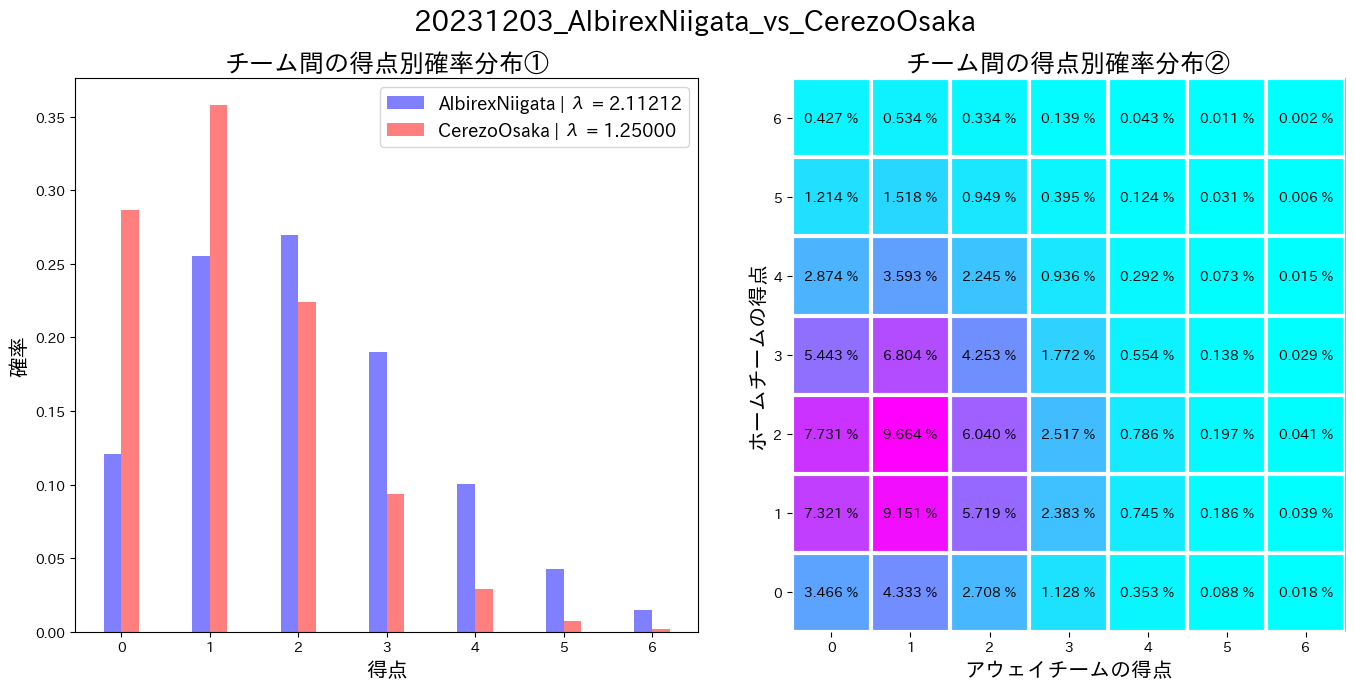

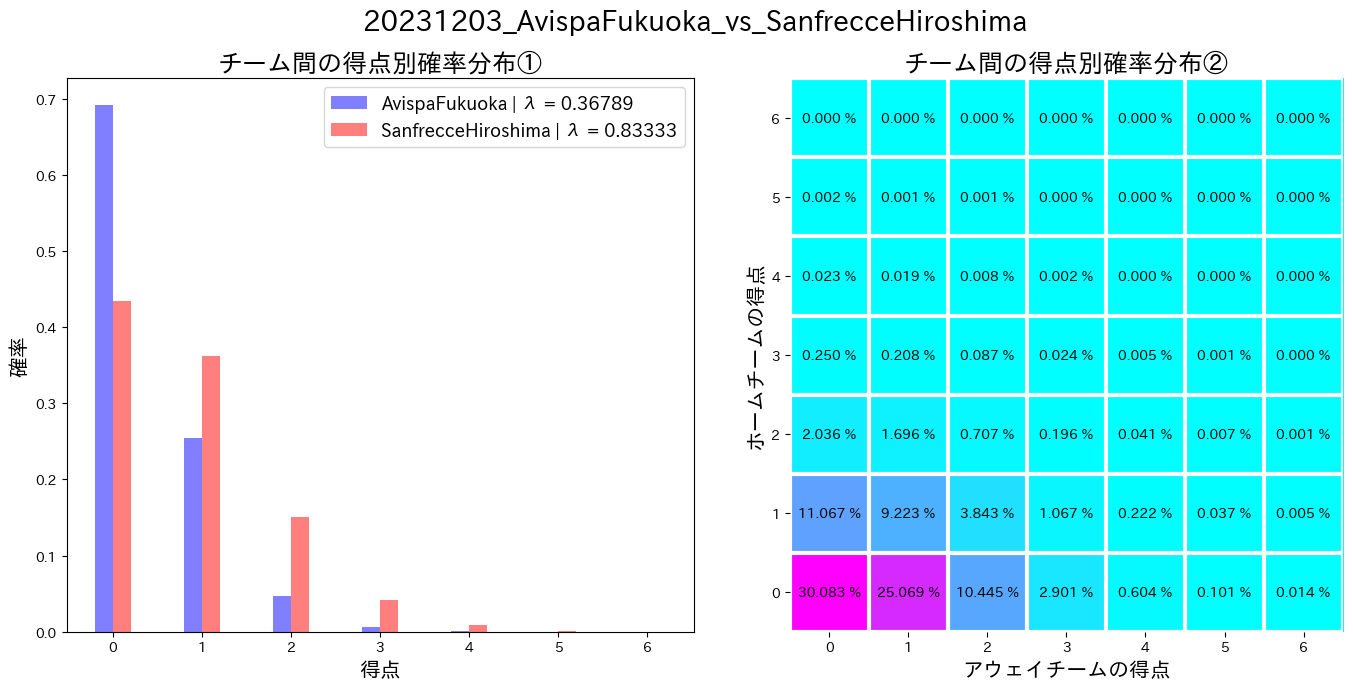

In [95]:
#目的変数で得られた得点がどの程度の頻度で発生するか棒グラフとヒートマップで可視化する
#軸メモリの作成
x = np.arange(0, 7, 1)

# game_flgのカラムがあれば削除
if 'game_flg' in df_test_data:
    df_test_data = df_test_data.drop(columns={'game_flg'})
    
for i, id in enumerate(home_id_list):
    # home_goalとaway_goalの発生率を5*5の正方行列として格納する。
    # appendしてるため。初期化しないと延々と追加されてしまう
    pref = []
    
    # idが一致するカラムを取得する
    df = df_test_data.loc[df_test_data['home_id'] == id]
    
    # ホームチームの目的変数を予測するための説明変数を格納する
    home_param = df[['home_power','streak_home','streak_away']].values
    
    # アウェイチームのidを取得する
    away_team_id = df['away_id'].values 
    # アウェイチームの目的変数を予測するための説明変数を格納する
    away_param = df[['away_power','streak_home','streak_away']].values

    # ホームチームのモデルをhome_listの要素から選択する
    home_id_index = np.where(home_id_list == id)[0][0]
    # アウェイチームのモデルをhome_id_listの要素(モデルの登録準がこのリストに準ずるため)から選択する
    away_id_index = np.where(home_id_list == away_team_id)[0][0]
    
    #学習させたモデルの当てはめ
    pred_home_goals = float(res_home[home_id_index].predict(home_param))
    pred_away_goals = float(res_away[away_id_index].predict(away_param))
    
    # poisson.pmf(num, goals_home)
    ## 確率関数を用いて確率密度を計算する関数。事象が平均して　λ = goals_home 発生する場合に、num回となる確率を求める
    ## 今回の場合、i=0~5の離散値それぞれで、goal_homeが起こる確率を計算する。計算された結果は長さ 5+1 のリスト型で返す    
    home_goal = [poisson.pmf(j, pred_home_goals) for j in x]
    away_goal = [poisson.pmf(j, pred_away_goals) for j in x]

    # １行２列の図を定義。（一度描写したら、リセットしない限り上乗せされるためfor文内で定義）
    ## 1列目に棒グラフ、２列目にヒートマップを描画する
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(14,7))

    # 棒グラフの描画（得点可能性xの中心に軸を置く。x±0.1に、太さ0.2の棒（home:blue, away:pink）を描画）
    ax[0].bar(x-0.1, 
              home_goal, 
              alpha = 0.5,
              label = df_team_name.loc[i, 'team.name_x'] + ' | λ = %.5f' % pred_home_goals,
              width = 0.2, 
              color = (0.0, 0.0, 1.0)
             )
    ax[0].bar(x+0.1, 
              away_goal, 
              alpha = 0.5,
              label = df_team_name.loc[i, 'team.name_y'] + ' | λ = %.5f' % pred_away_goals,
              width = 0.2, 
              color = (1.0, 0.0, 0.0)
             )
    
    # h_goal_perでhome_goalの0点になる確率を受け取り、away_goalの0~5点になる確率をかけて、同時確率分布を求める
    # パーセントであらわしたいので、100をかける 
    # ヒートマップにしたときy軸を降順にしたいためaway_goal.reverse()とする
    # home_goal = home_goal.reverse()とはしない。下記の記法で反映される
    
    for h_goal_per in home_goal:
        pref.append([h_goal_per * a_goal_per * 100 for a_goal_per in away_goal])

    # 利用する関数の定義に従い、２次元のリストを２次元のnumpy型配列に変換する
    perf_array = np.array(pref)
    #２次元配列の上下を反転する（0行目のデータが下側にくるように）
    perf_array = np.flip(perf_array, axis = 0)
    # ヒートマップの定義
    im = ax[1].imshow(perf_array)

    # heatmaps関数の呼び出し(引数の説明は関数部分を参照)
    # 今回カラーバーは受け取らないので,_とする
    im, _ = heatmap( perf_array, 
                 x[::-1], 
                 x, 
                 ax = ax[1], 
                 cmap = "cool",
                 bar = False
                )

    # annotate_heatmap関数の呼び出し
    # ヒートマップのマスに数値を黒で表示する
    texts = annotate_heatmap(im,
                             valfmt="{x:.3f} %",)
    
    # ax[1].xaxis.set_label_position('bottom')
    ax[0].legend(fontsize=13)
    # # 軸ラベルの設定
    ax[0].set_xlabel('得点', size=15)
    ax[0].set_ylabel('確率', size=15)
    ax[1].set_xlabel('アウェイチームの得点', size=15)
    ax[1].set_ylabel('ホームチームの得点', size=15)

    # タイトルの設定
    ## データフレームのj番目のインデックスを参照して、そのインデックスに対応している各チーム名、試合日程を登録している
    png_name = \
        df_team_name.loc[i, 'fixture.date'].astype(str) + '_' + df_team_name.loc[i, 'team.name_x'] + '_vs_' + df_team_name.loc[i, 'team.name_y']
    fig.suptitle(png_name, size=20)
    ax[0].set_title("チーム間の得点別確率分布①", size=18)
    ax[1].set_title("チーム間の得点別確率分布②", size=18)
    
    fig.tight_layout()
    fig.savefig('results/' + png_name + '.png')